In [1]:
# !conda install -r requirements.txt

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores.chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_groq.chat_models import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.runnables import RunnableParallel
from langchain_core.messages import HumanMessage, AIMessage
import warnings

warnings.filterwarnings("ignore")
load_dotenv(find_dotenv())

USER_AGENT environment variable not set, consider setting it to identify your requests.
/opt/homebrew/Caskroom/miniforge/base/envs/llm/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/llm/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3526: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code bas

True

In [3]:
GROQ_API_KEY = os.getenv("GROQQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]=LANGCHAIN_API_KEY
os.environ["LANGCHAIN_PROJECT"]="advanced-rag"
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [4]:
urls = [
    "https://www.webmd.com/a-to-z-guides/malaria",
    "https://www.webmd.com/diabetes/type-1-diabetes",
    "https://www.webmd.com/diabetes/type-2-diabetes",
    "https://www.webmd.com/migraines-headaches/migraines-headaches-migraines",
]

loader = WebBaseLoader(urls, bs_get_text_kwargs={"strip": True})
docs = loader.load()

In [5]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=30)
chunks = text_splitter.split_documents(docs)

embedding_function = HuggingFaceEmbeddings()

vector_store = Chroma.from_documents(documents=chunks, embedding=embedding_function)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [6]:
retriever.get_relevant_documents("Symptoms of migraine")

[Document(metadata={'description': 'Migraine headaches, also known as migraines, are a type of headache that can cause debilitating pain. Learn more about the types, causes, symptoms, diagnosis, & treatment of migraines.', 'language': 'en', 'source': 'https://www.webmd.com/migraines-headaches/migraines-headaches-migraines', 'title': 'Migraine: Symptoms, Causes, and Treatment'}, page_content='This pain may:Begin as a dull ache and then become throbbingGet worse duringphysical activityAffect one sideof your head or move from one side to the other, be in the front of your head, or affect your entire headDuring the headache, you may also:Have nausea (About 80% of people with migraine do, and about half vomit.)Be paleand clammyFeelfaintordizzyHave neck pain or stiffnessFeel anxious or depressedHave a runny nose or feel stuffed upBe sensitive to light(Noise or odors might also bother'),
 Document(metadata={'description': 'Migraine headaches, also known as migraines, are a type of headache th

In [7]:
class VectorStore(BaseModel):
    (
        "A vectorstore contains information about symptoms, treatment"
        ", risk factors and other information about malaria, type 1 and"
        "type 2 diabetes and migraines"
    )

    query: str


class SearchEngine(BaseModel):
    """A search engine for searching other medical information on the web"""

    query: str


router_prompt_template = (
    "You are an expert in routing user queries to either a VectorStore, SearchEngine\n"
    "Use SearchEngine for all other medical queries that are not related to malaria, diabetes, or migraines.\n"
    "The VectorStore contains information on malaria, diabetes, and migraines.\n"
    'Note that if a query is not medically-related, you must output "not medically-related", don\'t try to use any tool.\n\n'
    "query: {query}"
)

llm = ChatGroq(model="llama3-70b-8192", temperature=0)
prompt = ChatPromptTemplate.from_template(router_prompt_template)
question_router = prompt | llm.bind_tools(tools=[VectorStore, SearchEngine])

In [8]:
response = question_router.invoke("What are the symptoms of chest pain?")
"tool_calls" in response.additional_kwargs

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


True

In [9]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_65e7', 'function': {'arguments': '{"query":"chest pain symptoms"}', 'name': 'SearchEngine'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 1110, 'total_tokens': 1155, 'completion_time': 0.144144518, 'prompt_time': 0.094327391, 'queue_time': 0.011078187000000003, 'total_time': 0.238471909}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_87cbfbbc4d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-2dc6f2a2-333e-4475-8e7a-c7dd22d0db7c-0', tool_calls=[{'name': 'SearchEngine', 'args': {'query': 'chest pain symptoms'}, 'id': 'call_65e7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1110, 'output_tokens': 45, 'total_tokens': 1155})

In [10]:
from langchain_core.pydantic_v1 import validator

class Grader(BaseModel):
    "Use this format to give a binary score for relevance check on retrived documents."

    grade: Literal["relevant", "irrelevant"] = Field(
        ...,
        description="The relevance score for the document.\n"
        "Set this to 'relevant' if the given context is relevant to the user's query, or 'irrlevant' if the document is not relevant.",
    )

    @validator("grade", pre=True)
    def validate_grade(cls, value):
        if value == "not relevant":
            return "irrelevant"
        return value


grader_system_prompt_template = """"You are a grader tasked with assessing the relevance of a given context to a query. 
    If the context is relevant to the query, score it as "relevant". Otherwise, give "irrelevant".
    Do not answer the actual answer, just provide the grade in JSON format with "grade" as the key, without any additional explanation."
    """

grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grader_system_prompt_template),
        ("human", "context: {context}\n\nquery: {query}"),
    ]
)


grader_chain = grader_prompt | llm.with_structured_output(Grader, method="json_mode")

query = "symptoms of migraine"
context = retriever.get_relevant_documents(query)

response = grader_chain.invoke({"query": query, "context": context})

In [11]:
print(response)

grade='relevant'


In [12]:
query = "Treatment of Ulcer"
context = retriever.get_relevant_documents(query)

response = grader_chain.invoke({"query": query, "context": context})
print(response)

grade='irrelevant'


In [13]:
rag_template_str = (
    "You are a helpful assistant. Answer the query below based only on the provided context.\n\n"
    "context: {context}\n\n"
    "query: {query}"
)


rag_prompt = ChatPromptTemplate.from_template(rag_template_str)
rag_chain = rag_prompt | llm | StrOutputParser()

query = "What are the symptoms of malaria?"
context = retriever.get_relevant_documents(query)

response = rag_chain.invoke({"query": query, "context": context})

Markdown(response)

Based on the provided context, the symptoms of malaria include:

* Impaired consciousness
* Convulsions
* Difficulty breathing
* Serious tiredness and fatigue
* Dark or bloody urine
* Yellow eyes and skin (jaundice)
* Abnormal bleeding
* Very tired (fatigue)
* Body aches
* Yellow skin (jaundice)
* Kidney failure
* Seizure
* Confusion
* Bloody stools
* Convulsions
* Death
* High fever
* Chills
* Sweating
* Nausea or vomiting
* Headache
* Diarrhea
* Being very tired

Note that some of these symptoms may be similar to those of a cold or flu, and it's important to seek medical care as soon as possible if you suspect you may have malaria.

In [14]:
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "You are a friendly medical assistant created by NHVAI.\n"
        "Do not respond to queries that are not related to health.\n"
        "If a query is not related to health, acknowledge your limitations.\n"
        "Provide concise responses to only medically-related queries.\n\n"
        "Current conversations:\n\n{chat_history}\n\n"
        "human: {query}"
    )
)

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

fallback_chain.invoke(
    {
        "query": "Hello",
        "chat_history": [],
    }
)

"Hello! I'm happy to help with any health-related questions or concerns you may have. What's on your mind today?"

In [15]:
class HallucinationGrader(BaseModel):
    "Binary score for hallucination check in llm's response"

    grade: Literal["yes", "no"] = Field(
        ..., description="'yes' if the llm's reponse is hallucinated otherwise 'no'"
    )


hallucination_grader_system_prompt_template = (
    "You are a grader assessing whether a response from an llm is based on a given context.\n"
    "If the llm's response is not based on the given context give a score of 'yes' meaning it's a hallucination"
    "otherwise give 'no'\n"
    "Just give the grade in json with 'grade' as a key and a binary value of 'yes' or 'no' without additional explanation"
)

hallucination_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", hallucination_grader_system_prompt_template),
        ("human", "context: {context}\n\nllm's response: {response}"),
    ]
)


hallucination_grader_chain = (
    RunnableParallel(
        {
            "response": itemgetter("response"),
            "context": lambda x: "\n\n".join([c.page_content for c in x["context"]]),
        }
    )
    | hallucination_grader_prompt
    | llm.with_structured_output(HallucinationGrader, method="json_mode")
)

query = "Symptoms of malaria"
context = retriever.get_relevant_documents(query)
response = """Based on the context provided, the symptoms of malaria include: Impaired consciousness, Convulsions, Difficulty breathing,
Serious tiredness and fatigue, Dark or bloody urine, Yellow eyes and skin (jaundice), Abnormal bleeding, High fever, Chills,
Sweating, Nausea or vomiting, Headache, Diarrhea"""

response = hallucination_grader_chain.invoke({"response": response, "context": context})

In [16]:
response

HallucinationGrader(grade='no')

In [17]:
class AnswerGrader(BaseModel):
    "Binary score for an answer check based on a query."

    grade: Literal["yes", "no"] = Field(
        ...,
        description="'yes' if the provided answer is an actual answer to the query otherwise 'no'",
    )


answer_grader_system_prompt_template = (
    "You are a grader assessing whether a provided answer is in fact an answer to the given query.\n"
    "If the provided answer does not answer the query give a score of 'no' otherwise give 'yes'\n"
    "Just give the grade in json with 'grade' as a key and a binary value of 'yes' or 'no' without additional explanation"
)

answer_grader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", answer_grader_system_prompt_template),
        ("human", "query: {query}\n\nanswer: {response}"),
    ]
)


answer_grader_chain = answer_grader_prompt | llm.with_structured_output(
    AnswerGrader, method="json_mode"
)

query = "Symptoms of malaria"
# context = retriever.get_relevant_documents(query)
response = """Based on the context provided, the symptoms of malaria include: Impaired consciousness, Convulsions, Difficulty breathing,
Serious tiredness and fatigue, Dark or bloody urine, Yellow eyes and skin (jaundice), Abnormal bleeding, High fever, Chills,
Sweating, Nausea or vomiting, Headache, Diarrhea"""

response = answer_grader_chain.invoke({"response": response, "query": query})

In [18]:
response

AnswerGrader(grade='yes')

In [19]:
from typing import TypedDict
from langchain_core.documents import Document
from langgraph.prebuilt import ToolExecutor
from langchain_core.tools import Tool
from langchain_core.messages.base import BaseMessage

tavily_search = TavilySearchResults()
tool_executor = ToolExecutor(
    tools=[
        Tool(
            name="VectorStore",
            func=retriever.invoke,
            description="Useful to search the vector database",
        ),
        Tool(
            name="SearchEngine", func=tavily_search, description="Useful to search the web"
        ),
    ]
)


class AgentSate(TypedDict):
    """The dictionary keeps track of the data required by the various nodes in the graph"""

    query: str
    chat_history:list[BaseMessage]
    generation: str
    documents: list[Document]


def retrieve_node(state: dict) -> dict[str, list[Document] | str]:
    """
    Retrieve relevent documents from the vectorstore

    query: str

    return list[Document]
    """
    query = state["query"]
    documents = retriever.invoke(input=query)
    return {"documents": documents}


def fallback_node(state: dict):
    """
    Fallback to this node when there is no tool call
    """
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation}


def filter_documents_node(state: dict):
    filtered_docs = list()

    query = state["query"]
    documents = state["documents"]
    for i, doc in enumerate(documents, start=1):
        grade = grader_chain.invoke({"query": query, "context": doc})
        if grade.grade == "relevant":
            print(f"---CHUCK {i}: RELEVANT---")
            filtered_docs.append(doc)
        else:
            print(f"---CHUCK {i}: NOT RELEVANT---")
    return {"documents": filtered_docs}


def rag_node(state: dict):
    query = state["query"]
    documents = state["documents"]

    generation = rag_chain.invoke({"query": query, "context": documents})
    return {"generation": generation}


def web_search_node(state: dict):
    query = state["query"]
    results = tavily_search.invoke(query)
    documents = [
        Document(page_content=doc["content"], metadata={"source": doc["url"]})
        for doc in results
    ]
    return {"documents": documents}


def question_router_node(state: dict):
    query = state["query"]
    try:
        response = question_router.invoke({"query": query})
    except Exception:
        return "llm_fallback"

    if "tool_calls" not in response.additional_kwargs:
        print("---No tool called---")
        return "llm_fallback"

    if len(response.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide route!"

    route = response.additional_kwargs["tool_calls"][0]["function"]["name"]
    if route == "VectorStore":
        print("---Routing to VectorStore---")
        return "VectorStore"
    elif route == "SearchEngine":
        print("---Routing to SearchEngine---")
        return "SearchEngine"


def should_generate(state: dict):
    filtered_docs = state["documents"]

    if not filtered_docs:
        print("---All retrived documents not relevant---")
        return "SearchEngine"
    else:
        print("---Some retrived documents are relevant---")
        return "generate"


def hallucination_and_answer_relevance_check(state: dict):
    llm_response = state["generation"]
    documents = state["documents"]
    query = state["query"]

    hallucination_grade = hallucination_grader_chain.invoke(
        {"response": llm_response, "context": documents}
    )
    if hallucination_grade.grade == "no":
        print("---Hallucination check passed---")
        answer_relevance_grade = answer_grader_chain.invoke(
            {"response": llm_response, "query": query}
        )
        if answer_relevance_grade.grade == "yes":
            print("---Answer is relevant to question---\n")
            return "useful"
        else:
            print("---Answer is not relevant to question---")
            return "not useful"
    print("---Hallucination check failed---")
    return "generate"

In [20]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentSate)
workflow.add_node("VectorStore", retrieve_node)
workflow.add_node("SearchEngine", web_search_node)
workflow.add_node("filter_docs", filter_documents_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("rag", rag_node)

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "llm_fallback": "fallback",
        "VectorStore": "VectorStore",
        "SearchEngine": "SearchEngine",
    },
)

workflow.add_edge("VectorStore", "filter_docs")
workflow.add_edge("SearchEngine", "filter_docs")
workflow.add_conditional_edges(
    "filter_docs", should_generate, {"SearchEngine": "SearchEngine", "generate": "rag"}
)
workflow.add_conditional_edges(
    "rag",
    hallucination_and_answer_relevance_check,
    {"useful": END, "not useful": "SearchEngine", "generate": "rag"},
)

workflow.add_edge("fallback", END)

In [21]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

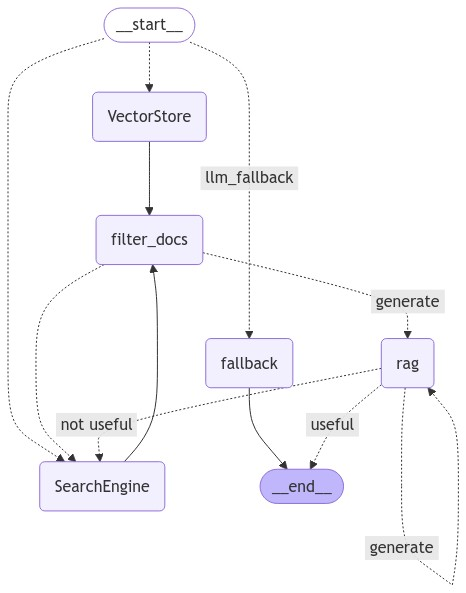

In [22]:
from io import BytesIO
from PIL import Image
from IPython.display import display

# Assuming you have the byte image stream in the 'byte_image' variable
img = Image.open(BytesIO(plot))
display(img)

In [23]:
for token in app.stream({"query": "What are the risk factors of migraines", "chat_history": []}):
    print(token, end="", flush=True)

---Routing to VectorStore---
{'VectorStore': {'documents': [Document(metadata={'description': 'Migraine headaches, also known as migraines, are a type of headache that can cause debilitating pain. Learn more about the types, causes, symptoms, diagnosis, & treatment of migraines.', 'language': 'en', 'source': 'https://www.webmd.com/migraines-headaches/migraines-headaches-migraines', 'title': 'Migraine: Symptoms, Causes, and Treatment'}, page_content="members who get them. If one parent has a history of thesetypes of headaches, you have a 50% chance of getting them. If both parents have them, the risk jumps to 75%.Other medical conditions.Depression,\xa0anxiety,bipolar disorder,sleep disorders, andepilepsycan raise your odds.Migraine TriggersSome things that may trigger an attack\xa0include:Hormone changes.You maynotice that you have headaches around your period, while you'repregnant, or when you'reovulating. Symptoms may also be tied to"), Document(metadata={'description': 'Migraine hea

In [24]:
response = app.invoke({"query": "What are the symptoms of hypertension", "chat_history": []})
Markdown(response["generation"])

---Routing to SearchEngine---
---CHUCK 1: RELEVANT---
---CHUCK 2: NOT RELEVANT---
---CHUCK 3: RELEVANT---
---CHUCK 4: RELEVANT---
---CHUCK 5: RELEVANT---
---Some retrived documents are relevant---
---Hallucination check passed---
---Answer is relevant to question---



Based on the provided context, the symptoms of hypertension mentioned are:

* Shortness of breath
* Dizziness
* Headaches
* Nosebleeds
* Frequent headaches
* Recurrent dizziness
* Nausea or vomiting

It's worth noting that high blood pressure often doesn't cause symptoms, and some sources mention that it usually doesn't have symptoms unless it's a medical emergency.

In [32]:
import gradio as gr
from uuid import uuid4

history = {}
session_id = str(uuid4())

def chat(query):
    documents=''
    # Initialize the chat history for the current session
    if session_id not in history:
        history[session_id] = []

    chat_history = history[session_id]

    # Invoke the app with the current query and chat history
    result = app.invoke({"query": query, "chat_history": chat_history})
    print(result)
    # Separate the response from the retrieved documents
    response = result["generation"]
    if "documents" in result.keys():
        documents = result["documents"]

    # Add the current exchange to the chat history
    chat_history.extend([HumanMessage(content=query), AIMessage(content=response)])

    if not documents:
        return response, documents
    else:

        documents = [
            f"{doc.page_content}\nsource: {doc.metadata['source']}" for doc in documents
        ]

    return response, "\n\n".join(documents)

# Create the Gradio interface
demo = gr.Interface(
    fn=chat,
    inputs=gr.Textbox(label="Question"),
    outputs=[gr.Textbox(label="Response"), gr.Textbox(label="Retrieved Documents")],
    title="RAG Chatbot",
    description="Ask a health-related query and the chatbot will generate a response using Retrieval Augmented Generation.",
)

# if __name__ == "__main__":
demo.launch(share=True, inline=True,debug=True)

Running on local URL:  http://127.0.0.1:7862


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running on public URL: https://2556410152e0a18c6c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


---No tool called---
{'query': 'hi', 'chat_history': [], 'generation': "Hi! I'm happy to help with any health-related questions or concerns you may have. What's on your mind today?"}
---Routing to VectorStore---
---CHUCK 1: RELEVANT---
---CHUCK 2: RELEVANT---
---CHUCK 3: RELEVANT---
---Some retrived documents are relevant---
---Hallucination check passed---
---Answer is relevant to question---

{'query': 'tell me about malaria', 'chat_history': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}), AIMessage(content="Hi! I'm happy to help with any health-related questions or concerns you may have. What's on your mind today?", additional_kwargs={}, response_metadata={})], 'generation': "Based on the provided context, here's what I can tell you about malaria:\n\n**Seriousness and Complications**: Malaria can be serious and sometimes life-threatening. It can lead to various problems, including coma, cerebral malaria (brain damage caused by swelling), pulmonary edema, liv